Mean power frequency #1 is 128.34 Hz.
Mean power frequency #2 is 144.01 Hz.
Mean power frequency #3 is 137.75 Hz.
Mean power frequency #4 is 134.01 Hz.
Mean power frequency #5 is 111.59 Hz.
Mean power frequency #6 is 115.47 Hz.


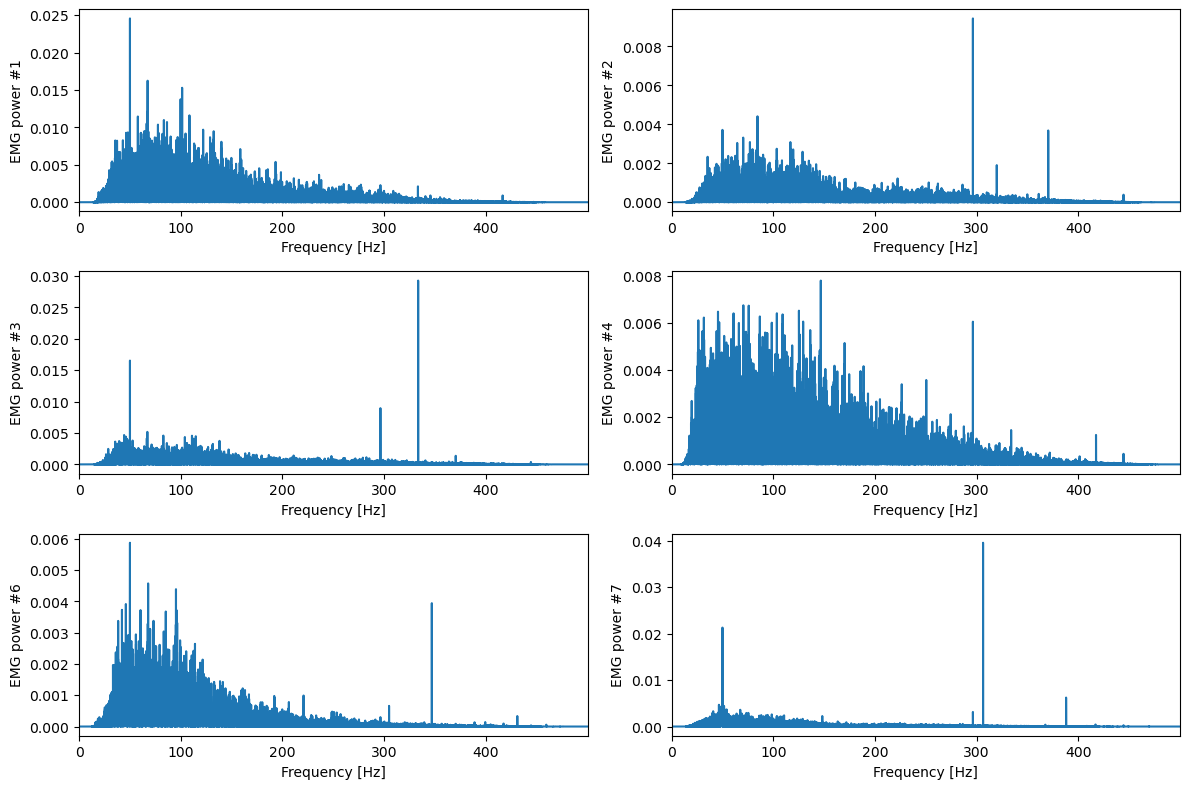

In [4]:
"""Analyze frequency spectrum of EMG data

Power spectrum of EMG data will be plotted.
Also, the mean power frequency will be displayed.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, integrate
from plot_emg import remove_offset


def main():
    # Setup variables
    freq_max = 500                                          # maximum frequency to be plotted [Hz]
    filename = "emg1.csv"  # filename of EMG data
    figname = "../results/Power_spectrum1.png"                          # filename of the output figure

    # Load an EMG data.
    df = pd.read_csv(filename, usecols=[0, 1, 21, 41, 61, 81, 101])

    # Remove not-available values in the end of the time column
    df = df.dropna()

    # Extract time and EMG data separately
    times = df.values[:, 0]   # time [s]
    data  = df.values[:, 1:]  # EMG values [V]

    # Process the EMG data
    # The cutoff frequencies of the band-pass filter was set based on the specification of the EMG sensors.
    # EMG Signal Bandwidth is 20 Hz to 450 Hz: https://trinoma.fr/wp-content/uploads/2018/11/Delsys-Trigno-EMG.pdf
    data = remove_offset(data)
    data = bpf(data, times, fc_low=20, fc_high=450)

    # Compute the frequency-range EMG signals
    amp, freq = compute_freq_spectrum(data, times)
    power = amp * amp  # power spectral density

    # Compute the mean power frequency
    mpf = np.round(compute_mean_power_frequency(power, freq), 2)
    for i in range(6):
        print("Mean power frequency #" + str(i+1) + " is " + str(mpf[i]) + " Hz.")

    # Compute plot range in x-axis (i.e., frequency-axis).
    # The maximum frequency of the plot is min(freq_max, max(freq)).
    positive_range = np.where(freq > 0)[0]  # only focus on positive frequency
    r1 = np.where(freq[positive_range] <= freq_max)[0][-1]  # final index of the plot range

    # Plot the data
    fig = plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = fig.add_subplot(3, 2, i+1)
        ax.plot(freq[positive_range], power[positive_range, i])
        ax.set_xlabel("Frequency [Hz]")
        if i >= 4:
            ax.set_ylabel("EMG power #" + str(i+2))
        else:
            ax.set_ylabel("EMG power #" + str(i+1))
        ax.set_xlim((freq[0], freq[r1]))
    fig.tight_layout()

    # Save the figure
    plt.savefig(figname)

    # Show the figure
    plt.show()


def bpf(data, times, fc_low, fc_high):
    """Apply a band-pass filter (BPF).

    In this function, the BPF is applied twice: once forward and once backward.
    The resultant filter has zero phase and a filter order twice that of the original.
    """
    # Setup constants
    n = 2               # order of a BPF. Note that the resultant order is doubled as the BPF is applied twice.
    fs = 1.0 / 9e-4     # sampling frequency [Hz]. Here, the sampling interval 0.9 ms is hard-coded.
    Wn_low  = fc_low  / (fs*0.5)  # lower cutoff frequency normalized by Nyquist frequency
    Wn_high = fc_high / (fs*0.5)  # higher cutoff frequency normalized by Nyquist frequency

    # Get numerator (b) and denominator (a) polynomials of the 2nd-order IIR Butterworth digital band-pass filter
    b, a = signal.butter(n, [Wn_low, Wn_high], btype="bandpass")

    # Apply the BPF.
    # Here, BPF is applied twice: once forward and once backward.
    # This is equivalent to an 4th-order zero-phase filter.
    data_filtered = signal.filtfilt(b, a, data, axis=0)

    return data_filtered


def compute_freq_spectrum(data, times):
    dt = 9e-4  # sampling interval [s]

    spectrum = np.fft.fft(data, axis=0)
    freq = np.fft.fftfreq(times.shape[0], dt)
    amp = abs(spectrum)  # Get the amplitude from complex values

    return amp, freq


def compute_mean_power_frequency(power, freq):
    # Setup variables
    positive_range = np.where(freq > 0)  # List of indices where frequency is positive
    S = power[positive_range]            # power spectral density in positive frequency range
    f = freq[positive_range]             # positive frequency
    f = np.expand_dims(f, axis=1)        # adjust array shape for array computation

    # Compute the mean power frequency
    # The composite Simpson's rule is used for integral.
    numerator = integrate.simps(S, f, axis=0)
    denominator = integrate.simps(f*S, f, axis=0)
    mpf = denominator / numerator

    return mpf


if __name__ == "__main__":
    main()
